In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read
from matplotlib.lines import Line2D
import pandas as pd
from kaldo.phonons import Phonons
from kaldo.forceconstants import ForceConstants
from kaldo.observables.secondorder import SecondOrder
from kaldo.interfaces.shengbte_io import read_second_order_qe_matrix
from sklearn.neighbors import KernelDensity
from scipy import constants as con
plt.style.use('/home/nwlundgren/spanners/matsci/miscellaneous/mpltstyle.txt')

# Unit conversions
# THz to cm-1
thz_to_invcm = con.value('hertz-inverse meter relationship')*1e12/100


# divide

	#264b96 blue
	#27b376 g1
	#006f3c g2
	#f9a73e y
	#bf212f r

2023-10-23 14:34:47.965754: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-23 14:34:47.994595: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/intel/oneapi/mkl/2023.2.0/lib/intel64:/opt/intel/oneapi/compiler/2023.2.0/linux/lib:/opt/intel/oneapi/compiler/2023.2.0/linux/lib/x64:/opt/intel/oneapi/compiler/2023.2.0/linux/compiler/lib/intel64_lin
2023-10-23 14:34:47.994637: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
layerheight = 25.8/3 #8.6A

# Bilayer Data collection >>>>>>
bic = '#264b96'
bipre = '../inse/classicalmd/bilayer/ald25/25_25_1/'
bilyr_f = np.load(bipre+'/frequency.npy').flatten()
bilyr_v = np.linalg.norm(np.load(bipre+'/velocity.npy'), axis=-1).flatten()
bilyr_ps = np.load('../inse/classicalmd/bilayer/ald25/25_25_1/300/quantum/tb_0.12091898428053205/_ps_and_gamma.npy')[:, 0].flatten()
bilyr_bw = np.load('../inse/classicalmd/bilayer/ald25/25_25_1/300/quantum/tb_0.12091898428053205/bandwidth.npy').flatten()
bilyr_k = np.load('../inse/classicalmd/bilayer/ald25/25_25_1/300/quantum/tb_0.12091898428053205/inverse/conductivity.npy')\
    .diagonal(axis1=1,axis2=2).mean(axis=-1).flatten() * 1.5
bilyr_k *= 51.03/layerheight
print('Bilayer Shapes:', [me.shape for me in [bilyr_f, bilyr_bw, bilyr_ps, bilyr_v, bilyr_k]])

bdosx = np.linspace(bilyr_f.min(), bilyr_f.max()+0.1, 300)
kde = KernelDensity(kernel='gaussian', 
                   bandwidth=0.053, \
                   ).fit(bilyr_f.reshape((-1,1)))
bdosy = np.exp(kde.score_samples(bdosx.reshape((-1,1))))

# Monolayer Data collection >>>>>>>
mic = '#27b376'
mopre = '../inse/classicalmd/monolayer/ald2525/15_15_1/'
molyr_f = np.load(mopre+'/frequency.npy').flatten()
molyr_v = np.linalg.norm(np.load(mopre+'/velocity.npy'), axis=-1).flatten()
molyr_ps = np.load('../inse/classicalmd/monolayer/ald2525/15_15_1/300/quantum/tb_0.12091898428053205/_ps_and_gamma.npy')[:, 0].flatten()
molyr_bw = np.load('../inse/classicalmd/monolayer/ald2525/15_15_1/300/quantum/tb_0.12091898428053205/bandwidth.npy').flatten()
molyr_k = np.load('../inse/classicalmd/monolayer/ald2525/15_15_1/300/quantum/tb_0.12091898428053205/inverse/conductivity.npy')\
    .diagonal(axis1=1,axis2=2).mean(axis=-1).flatten() * 1.5
molyr_k *= 50/layerheight
print('Monolayer Shapes:', [me.shape for me in [molyr_f, molyr_bw, molyr_ps, molyr_v, molyr_k]])

mdosx = np.linspace(molyr_f.min(), molyr_f.max()+0.1, 300)
kde = KernelDensity(kernel='gaussian', 
                   bandwidth=0.053, \
                   ).fit(molyr_f.reshape((-1,1)))
mdosy = np.exp(kde.score_samples(mdosx.reshape((-1,1))))

# Literature Data


Bilayer Shapes: [(15000,), (15000,), (15000,), (15000,), (15000,)]
Monolayer Shapes: [(2700,), (2700,), (2700,), (2700,), (2700,)]


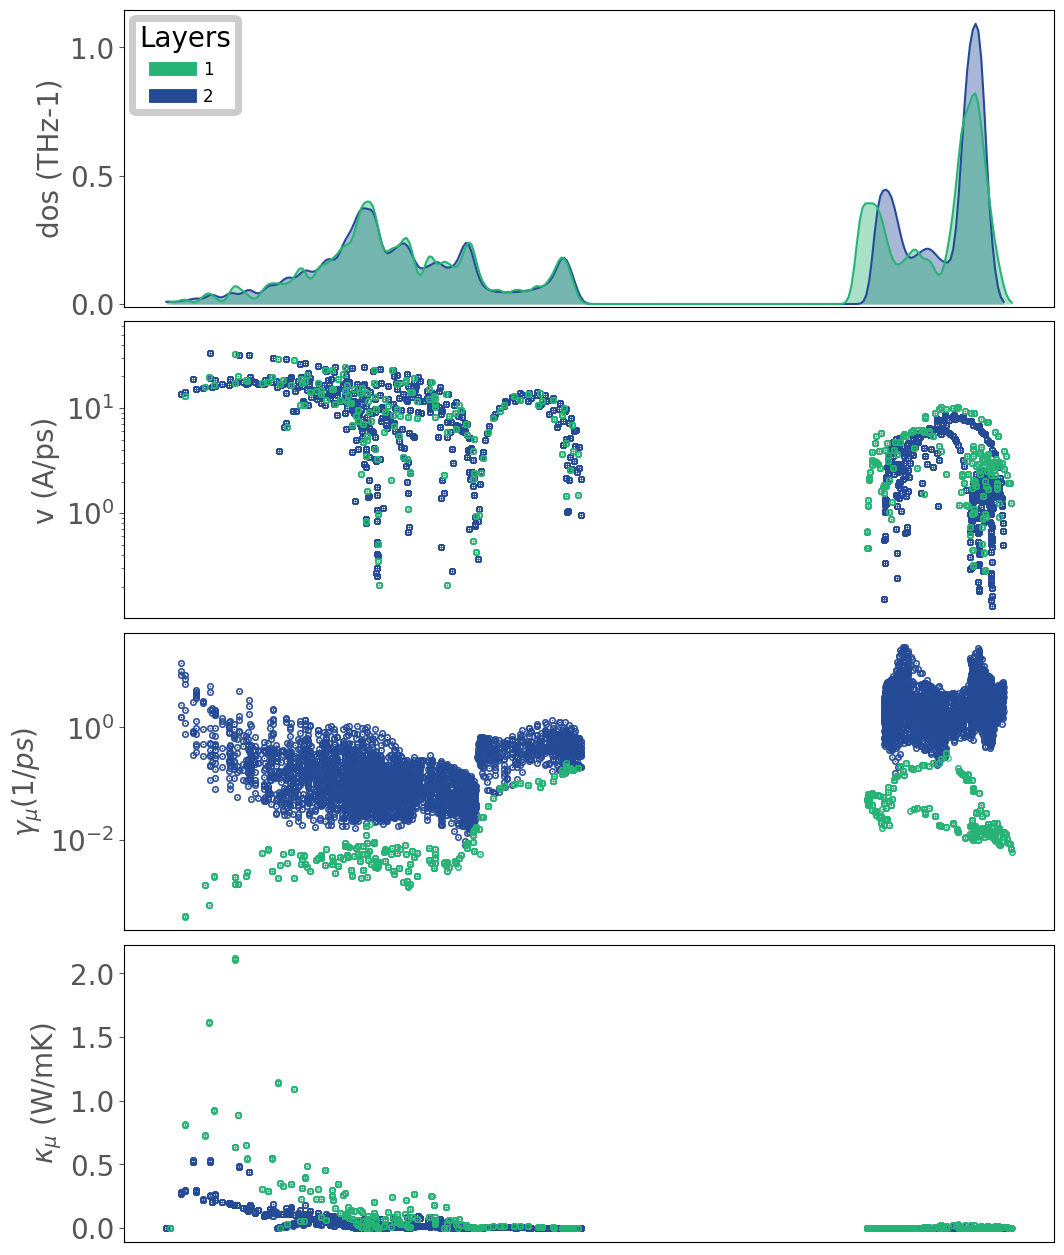

In [3]:
# autocomplete testing area
if None:
    np.load('../inse/MD_input/bilayer/ald25/25_25_1/300/quantum/tb_0.12091898428053205/rta/')

# Figure Adjustments >>>>
fig = plt.figure(figsize=(12, 16))
grid = plt.GridSpec(4, 1, wspace=0.05, hspace=0.05)
ax1 = fig.add_subplot(grid[0, 0])
ax2 = fig.add_subplot(grid[1, 0])
#ax3 = fig.add_subplot(grid[2, 0])
ax4 = fig.add_subplot(grid[2, 0])
ax5 = fig.add_subplot(grid[3, 0])
#axes = [ax1, ax2, ax3, ax4, ax5]
axes = [ax1, ax2, ax4, ax5]
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

# DoS
ax1.set_ylabel('dos (THz-1)')
ax1.plot(bdosx, bdosy, color=bic)
ax1.fill_between(bdosx, bdosy, 0, color=bic, alpha=0.4, linewidth=0.05)
ax1.plot(mdosx, mdosy, color=mic)
ax1.fill_between(mdosx, mdosy, 0, color=mic, alpha=0.4, linewidth=0.05)
ax1.set_ylim([-0.01, bdosy.max()*1.05])
ax1.set_yticks([0, 0.5, 1.0])

# Velocity
ax2.set_ylabel('v (A/ps)')
ax2.set_yscale('log')
ax2.scatter(bilyr_f, bilyr_v, color=bic, s=4, linewidth=4, marker='.', alpha=0.8)
ax2.scatter(molyr_f, molyr_v, color=mic, s=4, linewidth=4, marker='.', alpha=0.8)
ax2.set_ylim([0.1, bilyr_v.max()*2])
ax2.set_yticks([1.0, 10])

# Phase Space
# ax3.set_ylabel(r'$P_{3} (1/rad*ps)$')
# ax3.scatter(bilyr_f, bilyr_ps/(625*225), color=bic, s=4, linewidth=4, marker='.', alpha=0.8)
# ax3.scatter(molyr_f, molyr_ps/(225*225), color=mic, s=4, linewidth=4, marker='.', alpha=0.8)
# ax3.set_ylim([0, .1])
#ax3.set_yticks([0, 0.5, 1.0])

# Bandwidth
ax4.set_ylabel(r'$\gamma_{\mu} (1/ps)$')
ax4.set_yscale('log')
ax4.scatter(bilyr_f[6:], bilyr_bw[6:], color=bic, s=4, linewidth=4, marker='.', alpha=0.8)
ax4.scatter(molyr_f[6:], molyr_bw[6:], color=mic, s=4, linewidth=4, marker='.', alpha=0.8)
#ax3.set_ylim([0, 1])
#ax3.set_yticks([0, 0.5, 1.0])

# Cumulative Conductivity
ax5.set_ylabel(r'$\kappa_{\mu}$ (W/mK)')
ax5.set_yscale('linear')
ax5.scatter(bilyr_f, bilyr_k, color=bic, s=4, linewidth=4, marker='.', alpha=0.8)
ax5.scatter(molyr_f, molyr_k, color=mic, s=4, linewidth=4, marker='.', alpha=0.8)

wid = 10
mono = plt.Line2D([],[], color=mic, linewidth=wid)
bi = plt.Line2D([],[], color=bic, linewidth=wid)
ax1.legend([mono,bi], ['1', '2'], title='Layers', fontsize=12)

In [ ]:
litv = np.loadtxt('../inse/monolayer/latticedynamics/velocities-300K.csv')
litp3 = np.loadtxt('../inse/monolayer/latticedynamics/phasespace-300K.csv')


In [4]:
def phonon_getter(potential, fmt='hiphive'):
    forceconstants=ForceConstants.from_folder(
                supercell=(5,5,1),
                folder=potential,
                format=fmt,
                only_second=True)
    phonons=Phonons(forceconstants=forceconstants,
                    is_classic=True,
                    temperature=300,
                    folder=potential+'/ald/',
                    kpts=(5,5,1),
                    third_bandwidth=0.5/4.135)
    return phonons

def cumulative_conductivity(freq, cond, nbins=None, alpha=10):
    if nbins==None:
        nbins = int(freq.max() * alpha)
        print(f'Using {nbins}')
    fbin = np.linspace(freq.min(), freq.max(), nbins)
    return np.array([(cond[freq<k]).sum() for k in fbin])

In [129]:
bilyr_f[np.argwhere((bilyr_f>4))].min()

6.918562286096532

In [ ]:
# Indium Selenide
Plots to generate
- add up the bulk to my lattice dynamics plot
- make the HE convergence plot

# Amorphous Carbon


In [ ]:
hac = np.load('../inse/generation_3/fullerite/plotdata/hac.npy')
fig = plt.figure(figsize=(18, 12))
grid = plt.GridSpec(4, 1, wspace=0.3, hspace=0.2)
ax1 = fig.add_subplot(grid[0, :])
ax2 = fig.add_subplot(grid[1, :])
ax3 = fig.add_subplot(grid[2, :])
ax4 = fig.add_subplot(grid[3, :])
axes = [ax1, ax2, ax3, ax4]
dnorms = Normalize(vmin=2, vmax=fullerite['den'].max())
jet = cm.get_cmap('jet')

#dnorms = Normalize(vmin=2, vmax=fullerite['den'].max())
#jet = cm.get_cmap('jet')
#divider = make_axes_locatable(ax1)
#cax = divider.new_horizontal(size='5%', pad=0.8, pack_start=False)
#cax.yaxis.set_label_position('right')
#cax.yaxis.tick_right()
#fig.add_axes(cax)
#fig.colorbar(cm.ScalarMappable(norm=dnorms, cmap=jet), cax=cax)
#cax.set_xticks([])
#cax.set_yticks([2.0, 2.5, 3.0, 3.5])
#cax.set_ylabel('Density (g/cm3)')

for ax, model in zip(axes, hac):
    color = jet(dnorms(model['density']))
    stdhac = model['stdhac']
    meanhac = model['meanhac']
    hacbar = meanhac.mean(axis=-1)
    hp = hacbar+stdhac
    hm = hacbar-stdhac
    tau = np.arange(stdhac.size) * model['dtfs'] / 1000
    
    ax.plot(tau, meanhac[:, 0], color=color, alpha=0.6, linewidth=0.5)
    ax.plot(tau, meanhac[:, 1], color=color, alpha=0.6, linewidth=0.5)
    ax.plot(tau, meanhac[:, 2], color=color, alpha=0.6, linewidth=0.5)
    ax.plot(tau, hacbar, color=color, alpha=1)
    #ax.plot(tau, hp, color=color, alpha=0.8)
    #ax.plot(tau, hm, color=color, alpha=0.8)
    ax.fill_between(tau, hm, hp, color=color, alpha=0.3)

for ax in axes:
    ax.set_ylim([-5, 5])
    ax.set_xlim([5e-3, 250])
    ax.set_xscale('log')
    ax.set_ylabel('HFACF', fontsize=14)

ax4.set_xlabel('Correlation time (ps)')